In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Data Preprocessing

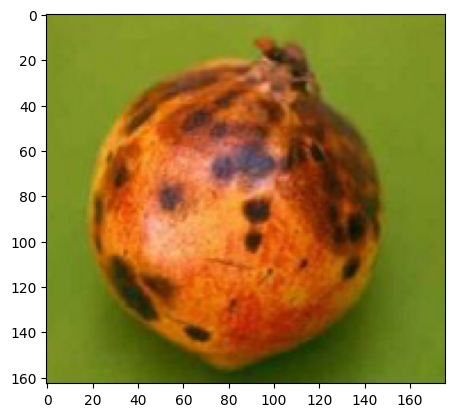

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

Train_DIR = '/Project/PomegranateGuard/images/train'
Categories = ['anthracnose', 'healthy', 'heartrot', 'sample']

for category in Categories:
    path = os.path.join(Train_DIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        old_image = cv2.imread(img_path)
        old_image = cv2.cvtColor(old_image, cv2.COLOR_BGR2RGB)  # Correctly convert BGR to RGB
        plt.imshow(old_image)
        plt.show()
        break
    break  # Remove this line if you want to iterate through all categories


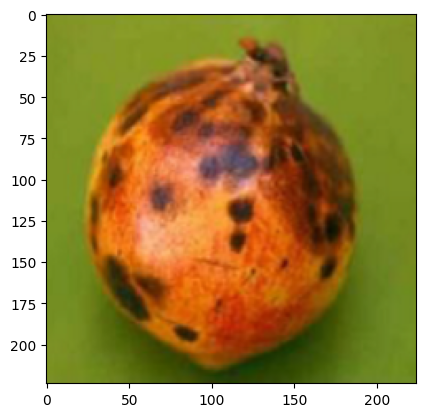

In [4]:
IMG_SIZE=224
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

# Model Prepration

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [6]:
IMGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMGE_SIZE + [3], weights='imagenet', include_top=False)


In [7]:
# don't train existing weights

for layer in inception.layers:
    layer.trainable = False

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target size for resizing images
IMG_SIZE = 224  # Example size, adjust according to your model requirements

# Define the new path for training and validation data
Train_DIR = '/Project/PomegranateGuard/images/train'

# Define ImageDataGenerator with augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Generate training data
train_datagen = datagen.flow_from_directory(
    directory=Train_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Generate validation data
val_datagen = datagen.flow_from_directory(
    directory=Train_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 354 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


In [9]:
from glob import glob

# Define the new path for the folders
folders = glob('/Project/PomegranateGuard/images/train')

# Print the list of folders found
print(folders)


['/Project/PomegranateGuard/images/train']


In [10]:
x = Flatten()(inception.output)
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,956,387 (83.76 MB)

 Trainable params: 153,603 (600.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [11]:
# Compile the Model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the new path for saving the model checkpoint
checkpoint_path = '/Project/PomegranateGuard/models/pomegranate_inceptionv3.h5'

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Combine callbacks into a list
callbacks = [checkpoint, earlystop]


In [13]:
# fit the model
# Run the cell. It will take some time to execute
model_history = model.fit(
  train_datagen,
  validation_data=val_datagen,
  epochs=10,
  steps_per_epoch=train_datagen.samples//16,
  validation_steps=val_datagen.samples//16,
  callbacks=callbacks)

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.7950 - loss: 6.0389

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 3.16741, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7979 - loss: 5.9879 - val_accuracy: 0.8750 - val_loss: 3.1674
Epoch 2/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 13s 655ms/step - accuracy: 1.0000 - loss: 4.4288e-04

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 3.16741 to 3.06988, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 1.0000 - loss: 4.4288e-04 - val_accuracy: 0.8750 - val_loss: 3.0699
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9063 - loss: 2.0060
Epoch 3: val_loss improved from 3.06988 to 0.45615, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 969ms/step - accuracy: 0.9075 - loss: 1.9684 - val_accuracy: 0.9625 - val_loss: 0.4562
Epoch 4/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - accuracy: 0.8750 - loss: 0.2260
Epoch 4: val_loss improved from 0.45615 to 0.26459, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.8750 - loss: 0.2260 - val_accuracy: 0.9625 - val_loss: 0.2646
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9672 - loss: 0.5004
Epoch 5: val_loss did not improve from 0.26459
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 873ms/step - accuracy: 0.9674 - loss: 0.4947 - val_accuracy: 0.9500 - val_loss: 0.7779
Epoch 6/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 11s 545ms/step - accuracy: 0.9375 - loss: 0.1150
Epoch 6: val_loss did not improve from 0.26459
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9375 - loss: 0.1150 - val_accuracy: 0.9500 - val_loss: 0.6076
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9862 - loss: 0.4299
Epoch 7: val_loss improved from 0.26459 to 0.03262, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 958ms/step - accuracy: 0.9864 - loss: 0.4211 - val_accuracy: 0.9875 - val_loss: 0.0326
Epoch 8/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 11s 552ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8: val_loss improved from 0.03262 to 0.01552, saving model to /Project/PomegranateGuard/models/pomegranate_inceptionv3.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9875 - val_loss: 0.0155
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9912 - loss: 0.1495
Epoch 9: val_loss did not improve from 0.01552
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 842ms/step - accuracy: 0.9912 - loss: 0.1493 - val_accuracy: 0.9375 - val_loss: 0.6350
Epoch 10/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10: val_loss did not improve from 0.01552
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9750 - val_loss: 0.2292
Restoring model weights from the end of the best epoch: 8.


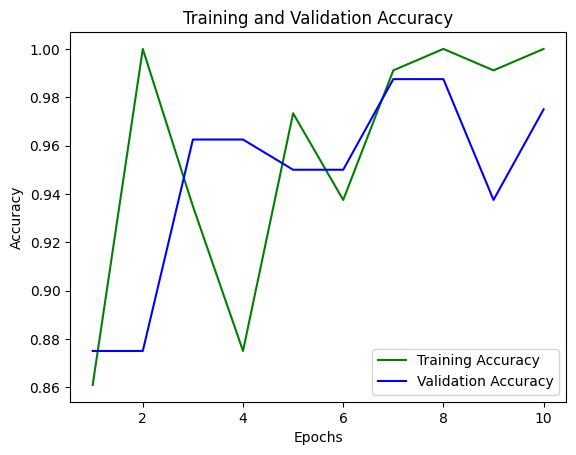

In [15]:
acc_train = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1, 11)  # Adjusted to match the number of epochs you used for training

plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


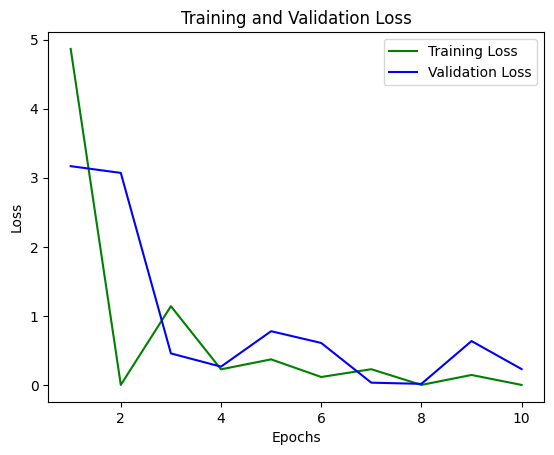

In [17]:
loss_train = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1, 11)  # Adjusted to match the number of epochs you used for training

plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Making the Prediction on a Single Image

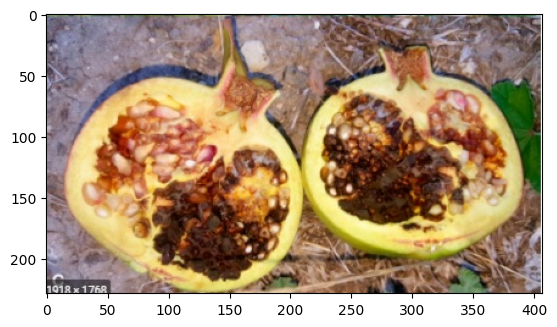

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


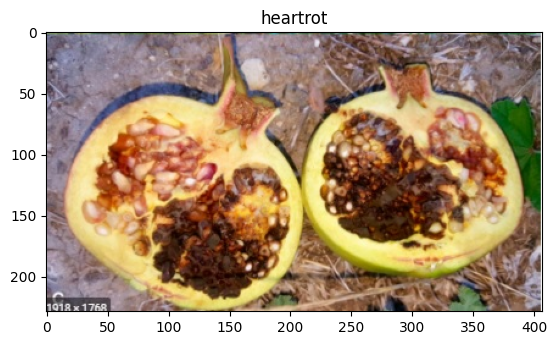

Predicted Class: heartrot


In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the new path for the test image
test_image_path = '/Project/PomegranateGuard/images/train/heartrot/5.jpg'

# Load and display the test image
image_result = plt.imread(test_image_path)
plt.imshow(image_result)
plt.show()

# Preprocess the test image
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Predict using the model
result = model.predict(test_image)
predicted_class = np.argmax(result)

# Define categories for interpretation (adjusted to 3 categories)
categories = ['anthracnose', 'healthy', 'heartrot']

# Display the prediction result
plt.imshow(image_result)
plt.title(categories[predicted_class])
plt.show()

print("Predicted Class:", categories[predicted_class])